## Model to predict Apple stock price using LSTM and data from TIINGO 

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## Data Collection

In [2]:
# Apple stock Data collected from TIINGO
import pandas_datareader as pdr

In [3]:
## Use your key from TIINGO to get data using API

df=pdr.get_data_tiingo('AAPL',api_key=mykey)

C:\Users\ADMIN\anaconda3\envs\spam\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('AAPL.csv')

In [5]:
df=pd.read_csv('AAPL.csv')

In [6]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-04-18 00:00:00+00:00,141.20,142.04,141.11,141.41,14697544,33.323740,33.521983,33.302500,33.373301,58790176,0.0,1.0
1,AAPL,2017-04-19 00:00:00+00:00,140.68,142.00,140.45,141.88,17328375,33.201018,33.512543,33.146737,33.484223,69313500,0.0,1.0
2,AAPL,2017-04-20 00:00:00+00:00,142.44,142.92,141.16,141.22,23319562,33.616385,33.729667,33.314300,33.328460,93278248,0.0,1.0
3,AAPL,2017-04-21 00:00:00+00:00,142.27,142.68,141.85,142.44,17320928,33.576264,33.673026,33.477143,33.616385,69283712,0.0,1.0
4,AAPL,2017-04-24 00:00:00+00:00,143.64,143.95,143.18,143.50,17116599,33.899590,33.972751,33.791028,33.866549,68466396,0.0,1.0


In [7]:
df1=df.reset_index()['close']

In [8]:
df1.tail()

1254    170.09
1255    165.75
1256    167.66
1257    170.40
1258    165.29
Name: close, dtype: float64

In [9]:
df.describe(include='all') # no data missing

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,1259,1259,1259.000000,1259.000000,1259.00000,1259.000000,1.259000e+03,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000
unique,1,1259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,AAPL,2017-04-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1259,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,191.858396,193.766725,189.70391,191.647566,5.429368e+07,81.292375,82.146380,80.353073,81.231182,1.196683e+08,0.009095,1.002383
std,NaN,NaN,68.392434,69.100585,67.33131,68.093439,4.041384e+07,45.237325,45.766437,44.654264,45.212665,5.519874e+07,0.077773,0.084549
min,NaN,NaN,106.840000,110.190000,103.10000,104.540000,1.136204e+07,33.201018,33.512543,33.146737,33.328460,4.099995e+07,0.000000,1.000000
25%,NaN,NaN,148.925000,149.795000,147.40500,148.700000,2.526365e+07,42.601806,42.860262,42.270459,42.573198,8.317129e+07,0.000000,1.000000
50%,NaN,NaN,172.790000,174.300000,171.26000,172.540000,3.693780e+07,57.713249,58.277430,57.203033,57.543995,1.048186e+08,0.000000,1.000000
75%,NaN,NaN,209.435000,211.945000,207.51000,209.860000,7.631092e+07,124.053570,125.280073,122.296243,123.849504,1.398241e+08,0.000000,1.000000


Text(0.5, 0, 'Date')

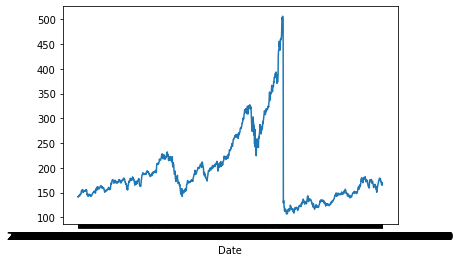

In [10]:
plt.plot(df['date'],df['close'])
plt.xlabel("Date")

## Data Preprocessing


In [11]:
df1.shape,df1[1159]

((1259,), 161.02)

In [12]:
## LSTM is sensitive to scale. So scaling using MinMaxScaler

scaler=MinMaxScaler(feature_range=(0, 1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
df1.shape,df1[1159]

((1259, 1), array([0.13570445]))

In [14]:
## train, validation, test split on time axis. First 60% data training, next 20% CV and next 20% testset.

train_size=int(len(df1)*.60)
cv_size=int(len(df1)*.20)
test_size=len(df1) -train_size-cv_size

train_set,cv_set,test_set=df1[0:train_size,:],df1[train_size:train_size+cv_size,:],df1[train_size+cv_size:len(df1),:1]


In [15]:
## funtion to create independent features and label set for dataset.
def create_train_dataset(dataset,time_step):
    data_X,data_y =[],[]
    for i in range(len(dataset)-time_step-1):
        ax=df1[i:(i+time_step),0]
        ay=df1[i+time_step,0]
        data_X.append(ax)
        data_y.append(ay)
    return np.array(data_X),np.array(data_y)


In [16]:
# function call to create independent features and label for training, CV and test dataset.
time_step=100
X_train,y_train=create_train_dataset(train_set,time_step)
X_cv,y_cv=create_train_dataset(cv_set,time_step)
X_test,y_test=create_train_dataset(test_set,time_step)


In [17]:
X_train[0], y_train[0]

(array([0.08606137, 0.08475892, 0.08916719, 0.08874139, 0.09217282,
        0.094402  , 0.09227301, 0.09254853, 0.09219787, 0.09953663,
        0.101866  , 0.10073889, 0.0994114 , 0.10549781, 0.11564183,
        0.11809643, 0.116268  , 0.11799624, 0.12338134, 0.12237946,
        0.12180338, 0.10872887, 0.11446462, 0.11576706, 0.11809643,
        0.11762054, 0.11646838, 0.11779587, 0.11714465, 0.11729493,
        0.11501565, 0.11606763, 0.12175329, 0.11794615, 0.11924859,
        0.12155291, 0.12060113, 0.1055479 , 0.09663118, 0.09956168,
        0.09597996, 0.09380088, 0.08874139, 0.0989355 , 0.09560426,
        0.0977583 , 0.09715717, 0.09878522, 0.09763306, 0.09239825,
        0.09765811, 0.09227301, 0.09312461, 0.09182217, 0.09329994,
        0.08989355, 0.09352536, 0.09572949, 0.0969067 , 0.09743269,
        0.10251722, 0.10569818, 0.10700063, 0.10830307, 0.11065748,
        0.10895429, 0.10877896, 0.11333751, 0.11496556, 0.11676894,
        0.10950532, 0.10685034, 0.10492173, 0.10

In [18]:
X_test[0], y_test[0]

(array([0.08606137, 0.08475892, 0.08916719, 0.08874139, 0.09217282,
        0.094402  , 0.09227301, 0.09254853, 0.09219787, 0.09953663,
        0.101866  , 0.10073889, 0.0994114 , 0.10549781, 0.11564183,
        0.11809643, 0.116268  , 0.11799624, 0.12338134, 0.12237946,
        0.12180338, 0.10872887, 0.11446462, 0.11576706, 0.11809643,
        0.11762054, 0.11646838, 0.11779587, 0.11714465, 0.11729493,
        0.11501565, 0.11606763, 0.12175329, 0.11794615, 0.11924859,
        0.12155291, 0.12060113, 0.1055479 , 0.09663118, 0.09956168,
        0.09597996, 0.09380088, 0.08874139, 0.0989355 , 0.09560426,
        0.0977583 , 0.09715717, 0.09878522, 0.09763306, 0.09239825,
        0.09765811, 0.09227301, 0.09312461, 0.09182217, 0.09329994,
        0.08989355, 0.09352536, 0.09572949, 0.0969067 , 0.09743269,
        0.10251722, 0.10569818, 0.10700063, 0.10830307, 0.11065748,
        0.10895429, 0.10877896, 0.11333751, 0.11496556, 0.11676894,
        0.10950532, 0.10685034, 0.10492173, 0.10

In [19]:
# reshaping
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_cv=X_cv.reshape(X_cv.shape[0],X_cv.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## LSTM based model creation

In [20]:
#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## Model training

In [23]:
model.fit(X_train,y_train,validation_data=(X_cv,y_cv),epochs=10)

Epoch 1/10
21/21 [==============================] - 10s 196ms/step - loss: 0.0155 - val_loss: 0.0024
Epoch 2/10
21/21 [==============================] - 2s 102ms/step - loss: 0.0023 - val_loss: 8.1825e-04
Epoch 3/10
21/21 [==============================] - 2s 103ms/step - loss: 0.0011 - val_loss: 3.0424e-04
Epoch 4/10
21/21 [==============================] - 2s 111ms/step - loss: 0.0011 - val_loss: 2.3432e-04
Epoch 5/10
21/21 [==============================] - 2s 106ms/step - loss: 9.8542e-04 - val_loss: 4.0014e-04
Epoch 6/10
21/21 [==============================] - 2s 101ms/step - loss: 9.1401e-04 - val_loss: 2.3550e-04
Epoch 7/10
21/21 [==============================] - 2s 100ms/step - loss: 8.3798e-04 - val_loss: 2.3424e-04
Epoch 8/10
21/21 [==============================] - 2s 101ms/step - loss: 8.1717e-04 - val_loss: 3.1717e-04
Epoch 9/10
21/21 [==============================] - 2s 100ms/step - loss: 6.6911e-04 - val_loss: 2.4223e-04
Epoch 10/10
21/21 [============================

## Predictions and Evaluation

In [27]:
train_predict=model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)

cv_predict=model.predict(X_cv)
cv_predict=scaler.inverse_transform(cv_predict)

y_pred_test=model.predict(X_test)

y_pred_test2=scaler.inverse_transform(y_pred_test)
y_test2=np.reshape(y_test,(152,1))
y_test2=scaler.inverse_transform(y_test2)

In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test2,y_pred_test2)

37.69848838905318

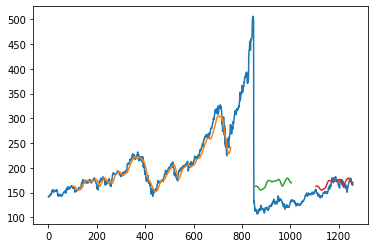

In [29]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
cvPredictPlot = np.empty_like(df1)
cvPredictPlot[:, :] = np.nan
cvPredictPlot[len(train_predict)+(look_back*2)+1:len(train_predict)+(look_back)+cv_size, :] = cv_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1+cv_size:len(df1)-1, :] = y_pred_test2

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(cvPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:
# x_input=test_set[153:].reshape(1,-1)
x_input=test_set[153:]
temp=x_input

In [31]:
## predict stock for next 30 days
from numpy import array
Pred_30=[]
i=0
while(i<30):
    x_input = x_input.reshape((1, 100,1))
    yhat = model.predict(x_input, verbose=0)
    temp=np.append(temp, yhat)
    x_input=temp[1+i:]
    Pred_30=np.append(Pred_30, yhat)
    i=i+1  


In [32]:
Pred_302d = np.reshape(Pred_30, (30,1))

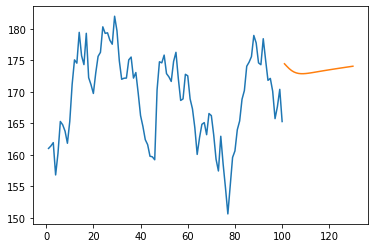

In [33]:
# plot last 100 days and next 30 days predictions
day_x1=np.arange(1,101)
day_x2=np.arange(101,131)

plt.plot(day_x1,scaler.inverse_transform(df1[1159:]))
plt.plot(day_x2,scaler.inverse_transform(Pred_302d))
plt.show()

In [34]:
df3=np.append(df1[1159:],Pred_302d)
df_final=np.reshape(df3,(130,1))

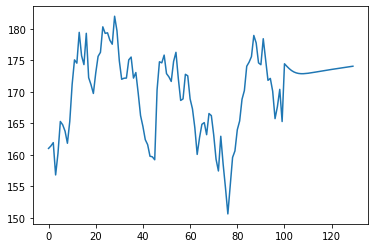

In [35]:
# plot last 100 days and next 30 days predictions

plt.plot(scaler.inverse_transform(df_final))
plt.show()

## Conclusion: LSTM based model making promising predictions assuming past trends continue in future.

## Thank you